This notebook is part of the `kikuchipy` documentation https://kikuchipy.org.
Links to the documentation won't work from the notebook.

# Fit a plane to selected projection centers

In this tutorial, we will fit a plane to projection centers (PCs) determined from a grid of (5, 5) EBSD patterns from a single crystal silicon wafer.
The resulting fitted plane contains one PC per pattern in the dataset from which the grid is obtained.
This plane of PCs can be used in subsequent indexing of the dataset.
To relate the sample positions of the grid to the PCs, we will test both an affine transformation and a projective transformation, following the work of <cite data-cite="winkelmann2020refined">Winkelmann et al. (2020)</cite>.

We'll start by importing necessary libraries

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import skimage.filters as skf

from diffsims.crystallography import ReciprocalLatticeVector
import kikuchipy as kp
from orix.crystal_map import PhaseList


plt.rcParams.update(
    {
        "figure.facecolor": "w",
        "figure.dpi": 75,
        "figure.figsize": (8, 8),
        "font.size": 15,
    }
)

/home/hakon/miniconda3/envs/kp-dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-08 16:38:25,967	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Load and inspect data

Load data lazily (~500 MB) and inspect its shape and step size

In [2]:
s = kp.data.si_wafer(allow_download=True, lazy=True)
s

<LazyEBSD, title: Pattern, dimensions: (50, 50|480, 480)>

We see that we have (50, 50) patterns of shape (480, 480), which is the full pattern resolution of the NORDIF UF-420 detector the patterns are acquired on.
In the axes manager

In [3]:
print(s.axes_manager)

<Axes manager, axes: (50, 50|480, 480)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |     50 |      0 |       0 |      40 |     um 
               y |     50 |      0 |       0 |      40 |     um 
---------------- | ------ | ------ | ------- | ------- | ------ 
              dx |    480 |      0 |       0 |       1 |     um 
              dy |    480 |      0 |       0 |       1 |     um 


... we see that the nominal step sizes are $(\Delta x, \Delta y) = (40, 40)$ $\mu$m.
The scan spans an area of $(2 \times 2)$ $\mu$m$^2$.
The NORDIF UF-420 detector pixel size (unbinned) is about 90 $\mu$m.
This means that, for example, we expect the PC to shift about 2000 / 90 $\approx$ 22 detector pixels when moving horizontally in the scan.
To get a better understanding of the expected changes of the PC in the scan, we'll look at the mean intensity map of the sample.

In [4]:
s_mean_nav = s.mean(axis=(2, 3))
s_mean_nav.compute()  # Need this call because data was loaded lazily

[########################################] | 100% Completed | 209.06 ms


Plot it, also annotating the orientation of the scan relative to the sample position in the chamber.
We use the [plot()](https://orix.readthedocs.io/en/stable/reference/generated/orix.crystal_map.CrystalMap.plot.html) method of the [EBSD.xmap](../reference/generated/kikuchipy.signals.EBSD.xmap.rst) attribute for this.

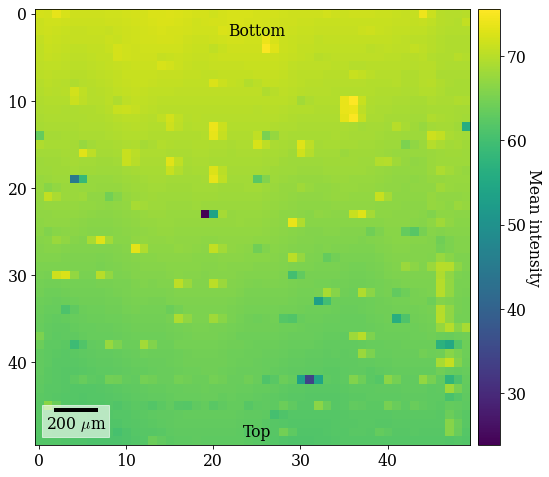

In [5]:
s.xmap.scan_unit = "um"
fig = s.xmap.plot(
    s_mean_nav.data.ravel(),
    colorbar=True,
    colorbar_label="Mean intensity",
    return_figure=True,
)

# Annotate
ax = fig.axes[0]
ax.text(25, 1, "Bottom", va="top", ha="center")
_ = ax.text(25, 49, "Top", va="bottom", ha="center");

The brighter and darker spots come from patterns acquired close to fiducial markers on the Si wafer, while the vertical gradient is a result of the Gaussian intensity distribution varying across the sample.
The orientation of the EBSD scan is important to note: To avoid depositing carbon ahead of the scanning beam, the sample is scanned from down the sample upwards, annotated in the map above ("Bottom", "Top").

The Bruker PC convention is used internally in kikuchipy.
The convention measures (PCx, PCy, PCz) in the following manner, viewing the detector from behind the detector towards the sample:

* PCx from left towards the right
* PCy downwards from the top
* PCz as the shortest distance from the beam-sample interaction position to the detector in fractions of the detector width.

See the [reference frames tutorial](reference_frames.ipynb) for more details and conversions between conventions.

Given this definition, let's annotate on the above map the expected changes to the PC (increasing in the direction of the arrow)

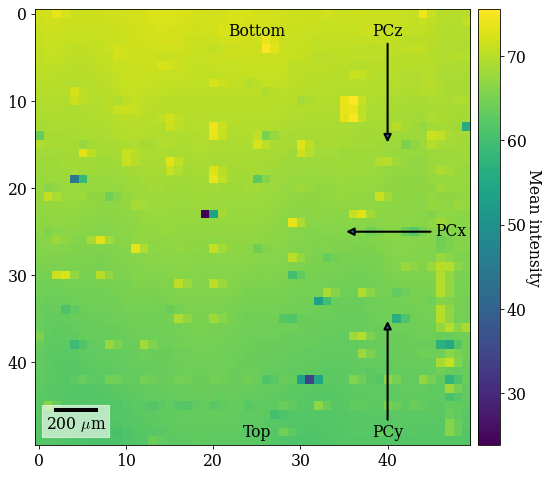

In [6]:
annotate_kw = dict(
    arrowprops=dict(arrowstyle="-|>", lw=2, mutation_scale=15)
)
xys = [(35, 25), (40, 35), (40, 15)]
xy_texts = [(49, 25), (40, 49), (40, 1)]
has = ["right", "center", "center"]
vas = ["center", "bottom", "top"]
labels = ["PCx", "PCy", "PCz"]
for xy, xytext, ha, va, label in zip(xys, xy_texts, has, vas, labels):
    ax.annotate(label, xy=xy, xytext=xytext, ha=ha, va=va, **annotate_kw)

fig  # Show figure again with new annotations

Our goal is to fit a plane of (PCx, PCy, PCz) to this (50, 50) map with these variations.
To this end, we will perform the following actions:

1. Extract an evenly spaced grid of patterns from the full dataset
2. Get initial guesses of the PC for each grid pattern with Hough indexing (from PyEBSDIndex)
3. Get initial guesses of the orientation for each grid pattern using the PCs with Hough indexing
4. Refine the orientations and PCs simultaneously by matching experimental to dynamically simulated patterns (simulated with EMsoft)
5. Fit a plane to the refined PCs

## Extract a grid of patterns

Before we extract the grid of patterns and prepare these for indexing by background correction, we obtain a binary mask to remove parts of the pattern without information (typically the corners).
We make the mask via thresholding, and find the threshold value by using the minimum threshold algorithm implemented in scikit-image; note that they have other thresholding algorithms that might work better for other datasets.

In [7]:
s_mean = s.mean((0, 1))  # (480, 480)
mean_data = s_mean.data.compute()

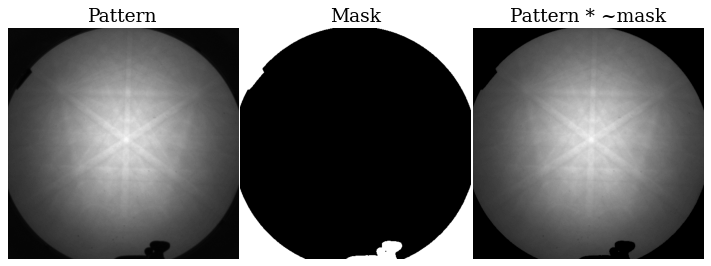

In [8]:
# Threshold
threshold = skf.threshold_minimum(mean_data)
signal_mask = mean_data < threshold

# Extract center pattern for plotting
p0 = s.inav[25, 25].data

fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
for ax, arr, title in zip(
    axes,
    [p0, signal_mask, p0 * ~signal_mask],
    ["Pattern", "Mask", "Pattern * ~mask"],
):
    ax.imshow(arr, cmap="gray")
    ax.axis("off")
    ax.set_title(title)
fig.subplots_adjust(wspace=0)

The mask efficiently removes the parts of the pattern which contains no information of interest.

Extract the grid using [EBSD.extract_grid()](../reference/generated/kikuchipy.signals.EBSD.extract_grid.rst)

In [9]:
grid_shape = (5, 5)
s_grid, idx = s.extract_grid(grid_shape, return_indices=True)

nav_shape_grid = s_grid.axes_manager.navigation_shape[::-1]
sig_shape_grid = s_grid.axes_manager.signal_shape[::-1]

s_grid.compute()

s_grid

[########################################] | 100% Completed | 101.84 ms


<EBSD, title: Pattern, dimensions: (5, 5|480, 480)>

Let's plot the grid positions on the navigation map

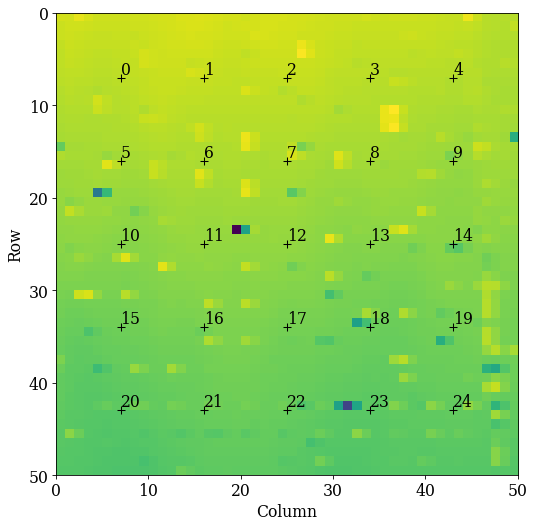

In [10]:
kp.draw.plot_pattern_positions_in_map(
    rc=idx.reshape(2, -1).T,
    roi_shape=(50, 50),
    roi_image=s_mean_nav.data,
)

We know that all patterns are of silicon.
To get a description of silicon, we could create a [Phase](https://orix.readthedocs.io/en/stable/reference/generated/orix.crystal_map.Phase.html) manually.
However, we will later on use a dynamically simulated EBSD master pattern of silicon (created with EMsoft), which is loaded with a `Phase`.
We will use this in the remaining analysis.

In [11]:
mp = kp.data.ebsd_master_pattern(
    "si", allow_download=True, projection="lambert", energy=20
)
mp

<EBSDMasterPattern, title: si_mc_mp_20kv, dimensions: (|1001, 1001)>

Extract the phase and change lattice constant unit from nm to Ångström

In [12]:
phase = mp.phase

lat = phase.structure.lattice
lat.setLatPar(lat.a * 10, lat.b * 10, lat.c * 10)

print(phase)
print(phase.structure)

<name: si. space group: Fd-3m. point group: m-3m. proper point group: 432. color: tab:blue>
lattice=Lattice(a=5.4307, b=5.4307, c=5.4307, alpha=90, beta=90, gamma=90)
14   0.000000 0.000000 0.000000 1.0000


## Initial guess of PC using Hough indexing

We will estimate PCs and do Hough indexing of the grid of patterns using [PyEBSDIndex](https://pyebsdindex.readthedocs.io).
See the [Hough indexing tutorial](hough_indexing.rst) for more details on the Hough indexing related commands below.

<div class="alert alert-info">

Note

PyEBSDIndex is an optional dependency of kikuchipy, and can be installed with both `pip` and `conda` (from `conda-forge`).
To install PyEBSDIndex, see their [installation instructions](https://pyebsdindex.readthedocs.io/en/latest/user/installation.html).

</div>

Prepare the patterns for indexing by background removal and setting the masked out values to 0

In [13]:
s_grid.remove_static_background()
s_grid.remove_dynamic_background()
s_grid = s_grid * ~signal_mask

[########################################] | 100% Completed | 101.19 ms
[########################################] | 100% Completed | 201.83 ms


Get an initial EBSD detector to store PC values in

In [39]:
det_grid = s_grid.detector.deepcopy()

print(det_grid)
print(det_grid.sample_tilt)

EBSDDetector (480, 480), px_size 1 um, binning 1, tilt 0.0, azimuthal 0.0, pc (0.5, 0.5, 0.5)
70.0


We need an [EBSDIndexer](https://pyebsdindex.readthedocs.io/en/stable/reference/generated/pyebsdindex.ebsd_index.EBSDIndexer.html) to use `PyEBSDIndex`.
We can obtain an indexer by passing a [PhaseList](https://orix.readthedocs.io/en/stable/reference/generated/orix.crystal_map.PhaseList.html) to [EBSDDetector.get_indexer()](../reference/generated/kikuchipy.detectors.EBSDDetector.get_indexer.rst)

In [40]:
phase_list = PhaseList(phase)
phase_list

Id  Name  Space group  Point group  Proper point group     Color
 0    si        Fd-3m         m-3m                 432  tab:blue

In [41]:
indexer = det_grid.get_indexer(phase_list, rSigma=1.5, tSigma=1.5)

We estimate the PC of each pattern with Hough indexing using [EBSD.hough_indexing_optimize_pc()](../reference/generated/kikuchipy.signals.EBSD.hough_indexing_optimize_pc.rst), and plot both the mean and standard deviation of the resulting PCs.
(We will "overwrite" the existing detector variable in memory.)

In [42]:
det_grid = s_grid.hough_indexing_optimize_pc(
    pc0=[0.52, 0.16, 0.50],  # Initial guess based on previous experiments
    indexer=indexer,
    batch=True,
    method="PSO",
    search_limit=0.1,
)

print(det_grid.pc_flattened.mean(axis=0))
print(det_grid.pc_flattened.std(0))


PC found: [**********] 25/25  global best:1.16  PC opt:[0.4958 0.1317 0.4946]]
[0.52245675 0.15755613 0.49552884]
[0.02364335 0.01884262 0.00986716]


Plot the PCs

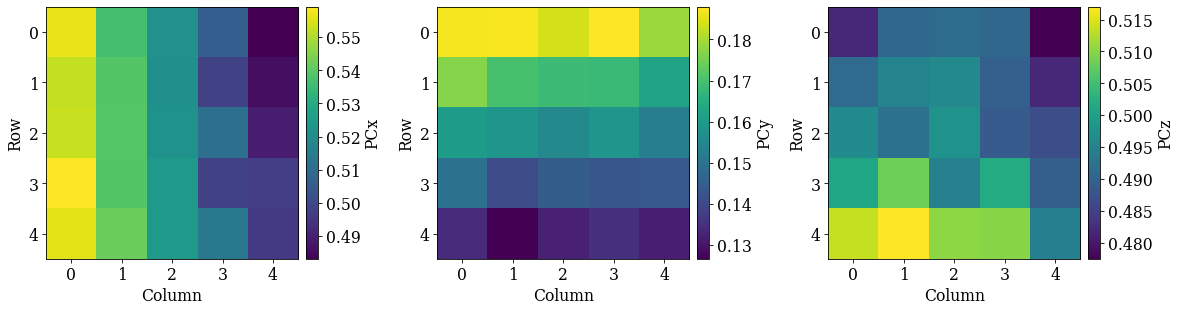

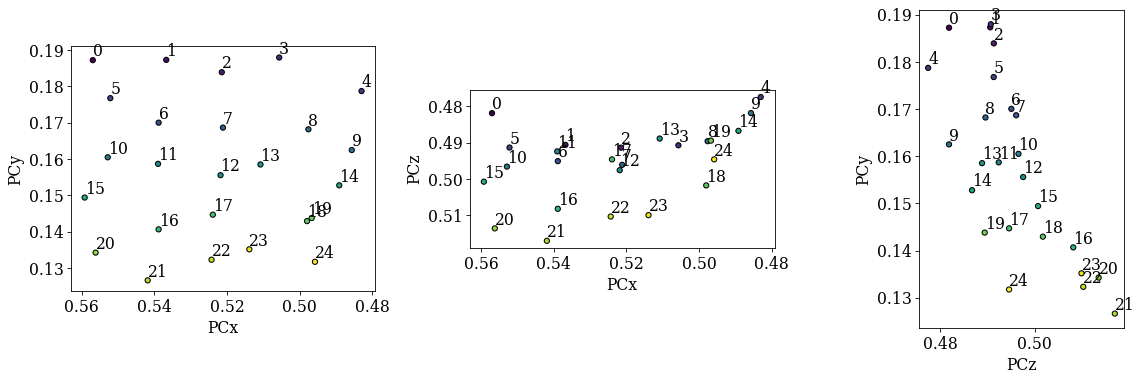

In [43]:
det_grid.plot_pc("map")
det_grid.plot_pc("scatter", annotate=True)

Looking at the maps:

* PCx increases towards the left, as expected.
* PCy increases upwards, as expected.
* PCz seems to increase downwards, as expected, although the right most column is not in line with the changes in the others.

Looking at the scatter plots:

* We recognize the regular (5, 5) grid in the (PCx, PCy) plot, although some patterns do not align as well as the others (e.g. 4 and 18).
* There is an inverse relation between PCy and PCz: as PCy decreases, PCz increases. This is as expected. However, there is a significant spread in each row of points (5-9, 10-14, etc.), and the right-most column seems to be shifted compared to the others.

These initial guesses seem OK and we could perhaps fit a plane to these values already.
But, we can get a better fit by refining the PC values using pattern matching.
To that end, we obtain initial guesses for the orientations via Hough indexing with [EBSD.hough_indexing()](../reference/generated/kikuchipy.signals.EBSD.hough_indexing.rst).
We get a new indexer with the optimized PCs from above and then index

In [44]:
indexer = det_grid.get_indexer(phase_list, rSigma=1.5, tSigma=1.5)

Hough indexing with PyEBSDIndex information:
  PyOpenCL: True
  Projection center (Bruker, mean): (0.5225, 0.1576, 0.4955)
  Indexing 25 pattern(s) in 1 chunk(s)
Radon Time: 0.04785463200096274
Convolution Time: 0.005574955997872166
Peak ID Time: 0.0030690519997733645
Band Label Time: 0.07174106199818198
Total Band Find Time: 0.12825794300078996
Band Vote Time:  0.018383151000307407
  Indexing speed: 141.86759 patterns/s


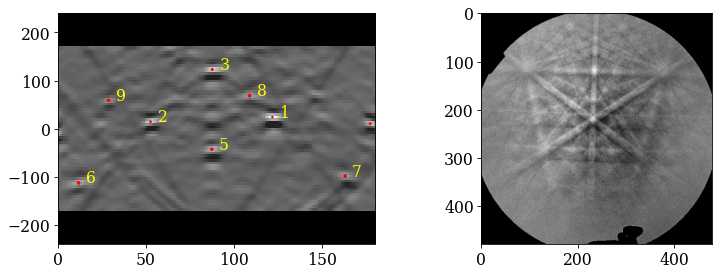

In [45]:
xmap_grid = s_grid.hough_indexing(
    phase_list=phase_list, indexer=indexer, verbose=2
)

Check the average pattern fit and confidence metric

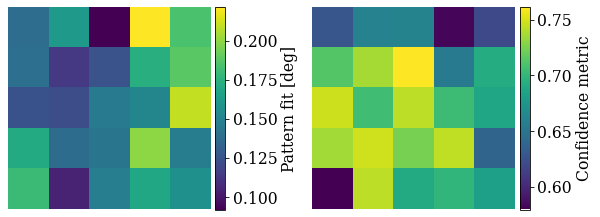

In [46]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 3.5))
for ax, to_plot, label in zip(
    axes, ["fit", "cm"], ["Pattern fit [deg]", "Confidence metric"]
):
    im = ax.imshow(xmap_grid.get_map_data(to_plot))
    fig.colorbar(im, ax=ax, label=label, pad=0.02)
    ax.axis("off")
fig.subplots_adjust(wspace=0.1)

Most patterns have a low pattern fit, and patterns 4, 14, and 18 have the highest fit.
Pattern 4 and 20 have the lowest confidence metric.

Let us refine these initial guesses of orientations and PCs using the loaded dynamically simulated master pattern.

## Refine PCs using pattern matching

Let's look at the dynamical simulation (which is in the square Lambert projection, required for use in dictionary indexing and refinement in kikuchipy [and EMsoft])

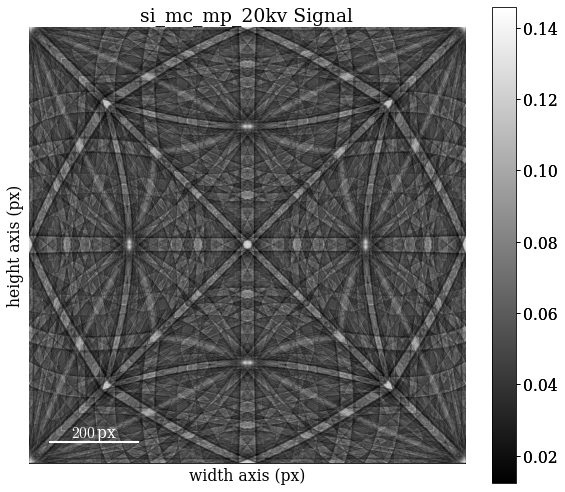

In [47]:
mp.plot()

Refine orientations and PCs using the Nelder-Mead optimization algorithm as implemented in NLopt.
During optimization, orientations are represented as three Euler angles, and are varied within a sufficiently wide trust region of +/- 5$^{\circ}$ of the orientation obtained from Hough indexing above.
PCs are varied within a trust region of +/- 10% of the detector width (for PCx and PCz) or height (for PCy).
Optimization of each pattern stops when the increase in normalized cross-correlation (NCC) score between iterations, obtained by comparing experimental to simulated pattern, is lower than $10^{-5}$.

In [48]:
xmap_grid_ref, det_grid_ref = s_grid.refine_orientation_projection_center(
    xmap=xmap_grid,
    detector=det_grid,
    master_pattern=mp,
    energy=20,
    signal_mask=signal_mask,
    method="LN_NELDERMEAD",
    trust_region=[5, 5, 5, 0.05, 0.05, 0.05],
    rtol=1e-5,
    chunk_kwargs=dict(chunk_shape=1),
)

Refinement information:
  Method: LN_NELDERMEAD (local) from NLopt
  Trust region (+/-): [5.   5.   5.   0.05 0.05 0.05]
  Relative tolerance: 1e-05
Refining 25 orientation(s) and projection center(s):
[########################################] | 100% Completed | 103.66 s
Refinement speed: 0.24114 patterns/s


Check the mean NCC score, mean PC and the standard deviation of the mean PC

In [24]:
print(xmap_grid_ref.scores.mean())
print(det_grid_ref.pc_average)
print(det_grid_ref.pc_flattened.std(0))

0.3329088526964188
[0.51928987 0.15477624 0.48650797]
[0.02412386 0.02052155 0.00728047]


Check the distribution of refined PCs

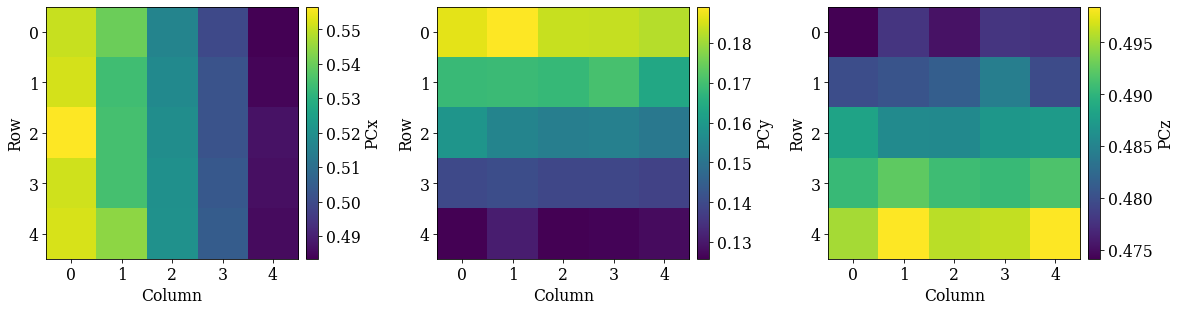

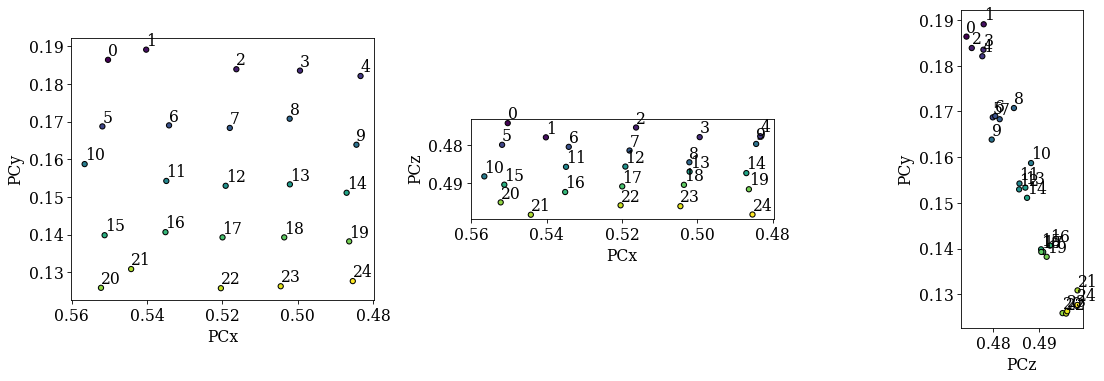

In [25]:
det_grid_ref.plot_pc("map")
det_grid_ref.plot_pc("scatter", annotate=True)

The grid is easily recognizable in all three scatter plots now.
If there were any outliers, we could exclude them by passing a boolean array when fitting a plane.
This array can either be created manually, or we can try to find outliers by robustly fitting a line to the (PCz, PCy) plot.
Assuming the sample is perfectly tilted about the detector $X_d$, the slope of the fitted line is the estimated tilt angle.

20.157382281198473


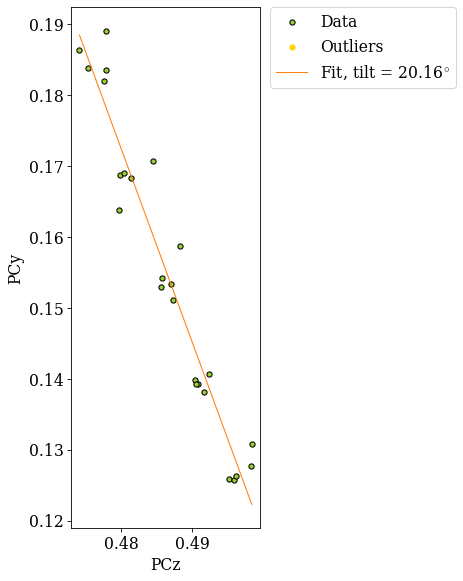

In [26]:
xtilt, is_outlier = det_grid_ref.estimate_xtilt(
    detect_outliers=True, degrees=True, return_outliers=True
)
print(xtilt)

The microscope was set to a tilt of 20$^{\circ}$, so this result is quite pleasing.

We can now fit a plane to the remaining PCs.

## Fit a plane to the refined PCs

To fit a plane to the PCs, we must pass an array of all indices in the full map and the indices of the patterns which the PCs were estimated from.
In the case of the grid patterns we've used here, the map indices were returned from the `EBSD.extract_grid()`.

In [28]:
nav_shape = s.axes_manager.navigation_shape[::-1]
map_indices = np.indices(nav_shape)

Using [EBSDDetector.fit_pc()](../reference/generated/kikuchipy.detectors.EBSDDetector.fit_pc.rst) we will fit a plane to the PCs using both an affine transformation and a projective transformation.
The fit method automatically plots the three scatter plots above and a forth 3D plot, with the experimental PC values shown as black circles and the fitted PCs corresponding to the experimental ones as larger gray circles.

EBSDDetector (480, 480), px_size 1 um, binning 1, tilt 0.0, azimuthal 0, pc (0.52, 0.156, 0.486)
70.6687419768525
[0.0014879  0.0016187  0.00108688]


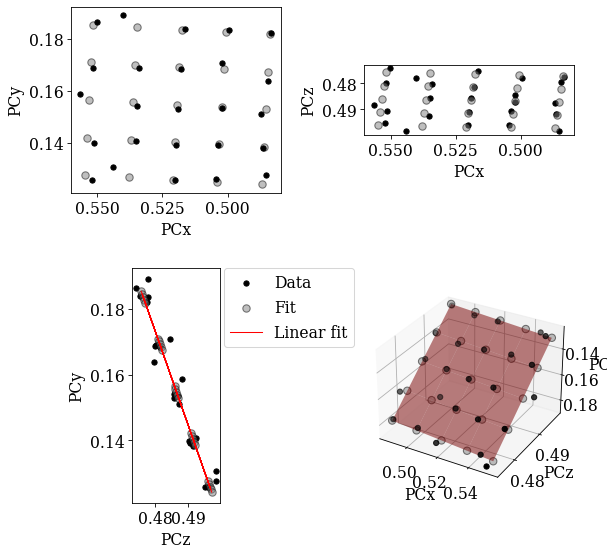

In [29]:
det_ref_aff = det_grid_ref.fit_pc(
    idx,
    map_indices=map_indices,
    transformation="affine",
)
print(det_ref_aff)

# Sample tilt
print(det_ref_aff.sample_tilt)

# Max. deviation between experimental and fitted PC
pc_diff_aff = det_grid_ref.pc - det_ref_aff.pc[tuple(idx)]
print(abs(pc_diff_aff.reshape(-1, 3)).mean(axis=0))

EBSDDetector (480, 480), px_size 1 um, binning 1, tilt 0.0, azimuthal 0, pc (0.52, 0.156, 0.486)
70.94367342843553
[0.00152321 0.00134688 0.00107174]


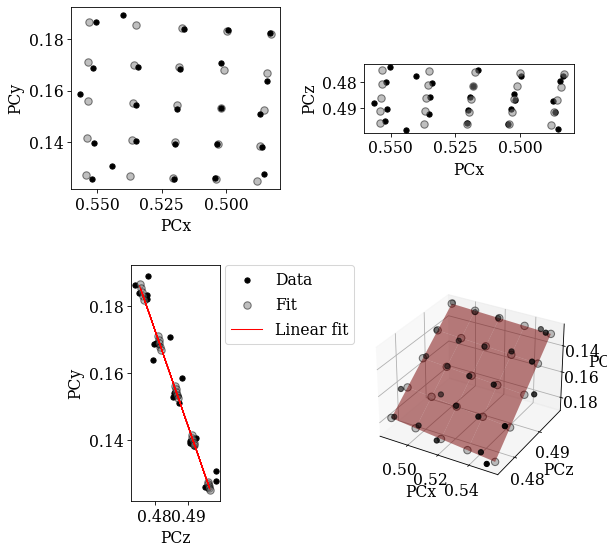

In [30]:
det_ref_proj = det_grid_ref.fit_pc(
    idx,
    map_indices=map_indices,
    transformation="projective",
)
print(det_ref_proj)

# Sample tilt
print(det_ref_proj.sample_tilt)

# Max. deviation between experimental and fitted PC
pc_diff_proj = det_grid_ref.pc - det_ref_proj.pc[tuple(idx)]
print(abs(pc_diff_proj.reshape(-1, 3)).mean(axis=0))

We see that the projective plane better fits the experimental PCs than the affine plane.
But all-in-all, both planes fit very well.

## Validate fitted PCs

Finally, we will refine the (already refined) orientations of the grid patterns using the above fitted PCs, and inspect geometrical simulations on top of all patterns.

In [31]:
det_ref_proj_grid = det_ref_proj.deepcopy()
det_ref_proj_grid.pc = det_ref_proj_grid.pc[tuple(idx)]

In [32]:
xmap_grid_refori = s_grid.refine_orientation(
    xmap=xmap_grid_ref,
    detector=det_ref_proj_grid,
    master_pattern=mp,
    energy=20,
    method="LN_NELDERMEAD",
    trust_region=[5, 5, 5],
    rtol=1e-5,
    signal_mask=signal_mask,
    chunk_kwargs=dict(chunk_shape=1),
)

print(xmap_grid_refori.scores.mean())

Refinement information:
  Method: LN_NELDERMEAD (local) from NLopt
  Trust region (+/-): [5 5 5]
  Relative tolerance: 1e-05
Refining 25 orientation(s):
[########################################] | 100% Completed | 21.27 ss
Refinement speed: 1.17462 patterns/s
0.33094716191291806


To plot geometrical simulations on top of our experimental patterns, we create a [KikuchiPatternSimulator](../reference/generated/kikuchipy.simulations.KikuchiPatternSimulator.rst) using the Si [Phase](https://orix.readthedocs.io/en/stable/reference/generated/orix.crystal_map.Phase.html) from the master pattern above (see the [geometrical EBSD simulations tutorial](geometrical_ebsd_simulations.ipynb) for more details)

In [33]:
rlv = ReciprocalLatticeVector.from_min_dspacing(phase)

# Ensure a complete unit cell (potentially changes the number of atoms)
rlv.sanitise_phase()

rlv.calculate_structure_factor()
structure_factor = abs(rlv.structure_factor)
rlv = rlv[structure_factor > 0.4 * structure_factor.max()]

rlv.print_table()

 h k l      d     |F|_hkl   |F|^2   |F|^2_rel   Mult 
 1 1 1    3.135    18.4     338.2     100.0      8   
 2 2 0    1.920    15.0     224.0      66.2      12  
 4 0 0    1.358     9.2     83.7       24.8      6   
 3 1 1    1.637     8.5     72.4       21.4      24  


In [34]:
simulator = kp.simulations.KikuchiPatternSimulator(rlv)

Get one simulation per pattern

In [35]:
sim = simulator.on_detector(
    det_ref_proj_grid,
    xmap_grid_refori.rotations.reshape(*xmap_grid_refori.shape),
)

Finding bands that are in some pattern:
[########################################] | 100% Completed | 105.34 ms
Finding zone axes that are in some pattern:
[########################################] | 100% Completed | 101.75 ms
Calculating detector coordinates for bands and zone axes:
[########################################] | 100% Completed | 101.38 ms


Plot the geometrical simulations on top of the patterns

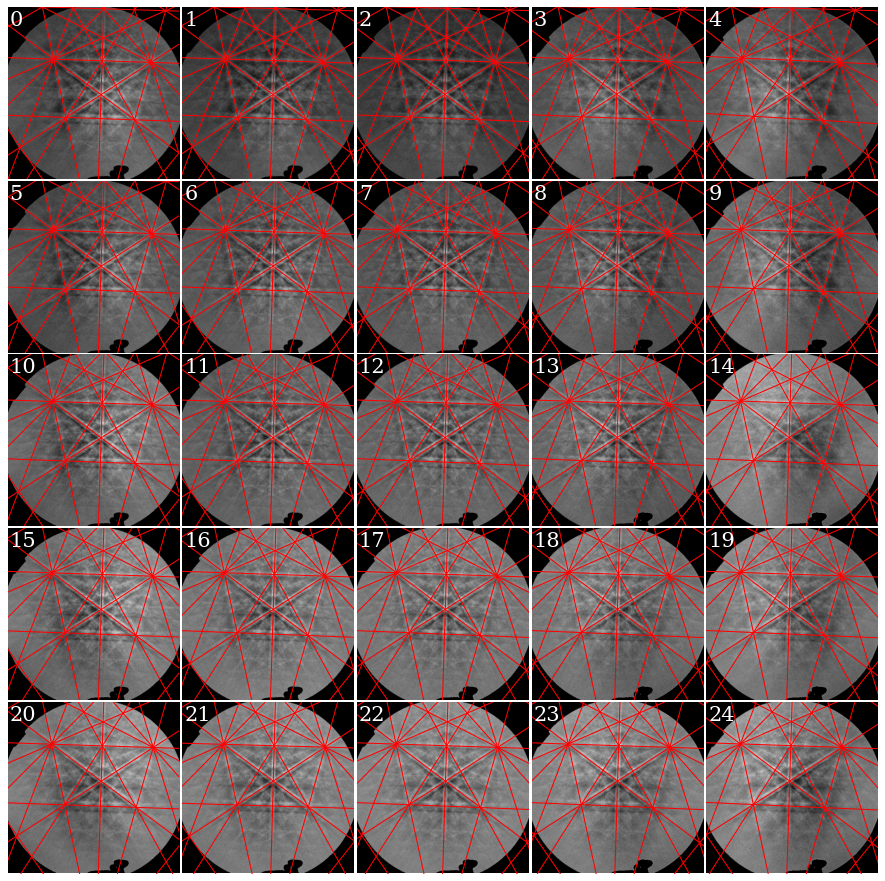

In [36]:
fig, axes = plt.subplots(*grid_shape, figsize=(15, 15))
for i in np.ndindex(grid_shape):
    axes[i].imshow((s_grid.data[i]), cmap="gray")
    axes[i].axis("off")

    lines = sim.as_collections(i)[0]
    axes[i].add_collection(lines)

    idx1d = np.ravel_multi_index(i, grid_shape)
    axes[i].text(5, 10, idx1d, c="w", va="top", ha="left", fontsize=20)

fig.subplots_adjust(wspace=0.01, hspace=0.01)

As expected, if we look at the first pattern (0), we see that the patterns shift upwards and to the left as we move down (see how the upper-most near-horizontal Kikuchi line shifts) and to the right (see how the the lower left line shifts) in the grid.

The patterns come from a single crystal.
How misoriented is the estimated orientation for the center pattern to the other orientations?

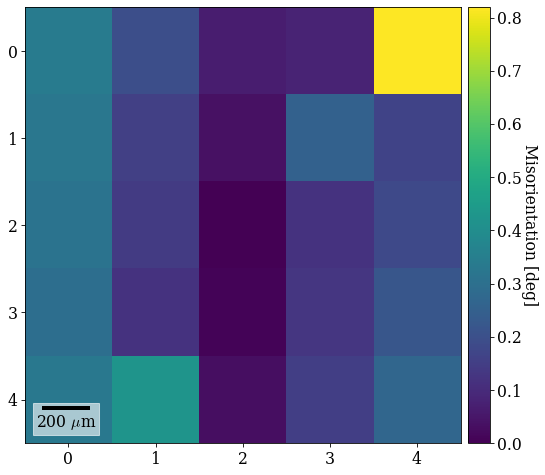

In [37]:
m = xmap_grid_refori.orientations[12].angle_with(
    xmap_grid_refori.orientations, degrees=True
)
xmap_grid_refori.plot(m, colorbar=True, colorbar_label="Misorientation [deg]")

We see that it is the least misoriented to the closest patterns, while the misorientation increases outwards radially.
All misorientations are < 0.7$^{\circ}$.